In [1]:
import jax
from jax import lax, random, numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten

import flax
from flax import linen as nn

import sympy as sy
import numpy as np

import sys
sys.path.append("..")
sys.path.append("../../orient/")

from eql.eqlearner import EQL, EQLdiv
from eql.symbolic import get_symbolic_expr_div, get_symbolic_expr
from eql.np_utils import flatten, unflatten

import optax
import scipy
from functools import partial
import matplotlib.pyplot as plt

In [3]:
funs = ['mul', 'sin', 'id', 'id', 'id']*3
e = EQLdiv(n_layers=1, functions=funs, features=1)
key = random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


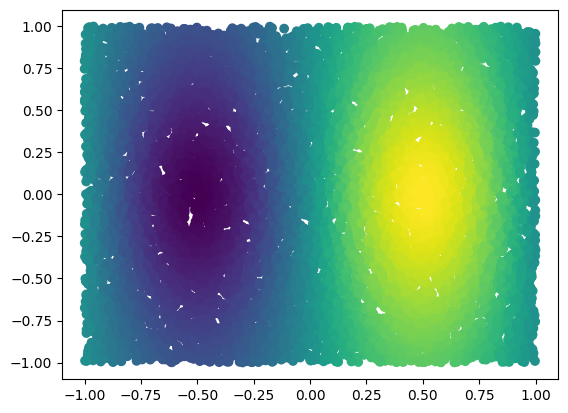

In [4]:
N = 10000
xdim = 2
x = (random.uniform(key, (N, xdim))-.5) * 2
#x = np.array([[1., 2.]]).T
#x = np.linspace(-1, 1, N)[:,None]
#y = x[:,0] + jnp.cos(x[:,1])
#y = (jnp.cos(x) + 1 - x**2)/(x-3)**3


y = np.sin(np.pi * x[:,0])/(x[:,1]**2 + 1)
plt.scatter(x[:,0], x[:,1], c=y)

In [5]:
params = e.init({'params':key}, x, 1.0);

In [119]:
out, b = e.apply(params, x, 1e-4)

In [6]:
def mse_fn(params, threshold):
    pred, _ = e.apply(params, x, threshold)
    return jnp.mean((pred-y)**2)

def mse_b_fn(params, threshold):
    pred, b = e.apply(params, x, threshold)
    return jnp.mean((pred-y)**2), b


def get_mask_spec(thresh, params):
    flat, spec = tree_flatten(params)
    mask = [jnp.abs(f) > thresh for f in flat]
    return mask, spec

def apply_mask(mask, spec, params):
    flat, _ = tree_flatten(params)
    masked_params = tree_unflatten(spec, [f*m for f,m in zip(flat, mask)])
    return masked_params


def get_masked_mse(thresh, params):
    mask, spec = get_mask_spec(thresh, params)
    def masked_mse(params, threshold):
        masked_params = apply_mask(mask, spec, params)
        return mse_fn(masked_params, threshold)
    return jax.jit(masked_mse)
    

def l1_fn(params):
    return sum(
        #jnp.abs(w).mean() for w in jax.tree_leaves(params["params"])
        jnp.mean(w**2) for w in jax.tree_leaves(params["params"])
    )

def penalty_fn(threshold, b):
    return (jnp.maximum(0, threshold - b)).sum()

In [7]:
def get_loss(lamba):
    def loss_fn(params, threshold):
        mse, b = mse_b_fn(params, threshold)
        return mse  + lamba * l1_fn(params) + penalty_fn(threshold, b)
    return loss_fn

def get_loss_grad(lamba):
    loss = get_loss(lamba)
    return jax.jit(jax.value_and_grad(loss))

In [8]:
loss_grad_fn = get_loss_grad(0)

In [9]:
spec, flat = flatten(params)
def np_fn(loss_grad_fn, start_iteration=0):
    def fn(fparams):
        fn.iteration += 1
        params = unflatten(spec, fparams)

        loss, grad = loss_grad_fn(params, 1./np.sqrt(fn.iteration + 1))
        _, grad = flatten(grad)

        #print(loss)

        return loss, np.array(grad)
    fn.iteration = start_iteration
    return fn

In [10]:
def optimize(loss_grad_fn, init):
    x0, f, info = scipy.optimize.fmin_l_bfgs_b(
        loss_grad_fn,
        x0 = np.array(init),
        factr=1.,
        m=500,
        pgtol=1e-13,
        maxls=100)
    print(f)
    return x0

In [11]:
loss_grad_1 = get_loss_grad(0)
loss_grad_2 = get_loss_grad(8e-1)

In [12]:
def fit(key):
    params = e.init({'params':key}, x, 1.0)
    spec, flat = flatten(params)
    res1 = optimize(np_fn(loss_grad_1), flat)
    res2 = optimize(np_fn(loss_grad_2, int(1e9)), res1)
    
    params = unflatten(spec, res2)
    thr = 1e-3
    mask, mspec = get_mask_spec(thr, params)
    loss_grad_masked = jax.jit(jax.value_and_grad(get_masked_mse(thr, params)))
    
    
    res3 = optimize(np_fn(loss_grad_masked, int(1e12)), res2)
    return get_symbolic_expr_div(apply_mask(mask, mspec, params), funs)[0]
    

In [13]:
key, _ = random.split(key)
fit(key)

/tmp/ipykernel_183989/1105523605.py:32: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  jnp.mean(w**2) for w in jax.tree_leaves(params["params"])


8.921808197824913e-15
0.14042003452777863
0.043481357395648956


(-0.0919965303638662*x0 - 0.0140451499725537*x1 - 0.0560633428394794*(-0.436186820268631*x0 + 0.1076545342803*x1 - 0.0278660394251347)*(0.280517280101776*x0 - 0.15554091334343*x1 + 0.341708123683929) - 0.0178914368152618*(-0.245047152042389*x0 - 0.0980248972773552*x1 + 0.0930218249559402)*(0.321418404579163*x0 + 0.0933654382824898*x1 - 0.0352215468883514) - 0.00743753230199218*(-0.0604024231433868*x0 - 0.0505754947662354*x1 + 0.0762020871043205)*(0.00161728577222675*x0 - 0.0663560703396797*x1 - 0.139010801911354) + 0.277519553899765*sin(0.589197754859924*x0 + 0.110335685312748) - 0.023394949734211*sin(0.0332068838179111*x0 + 0.00616597151383758*x1 + 0.0166980810463428) - 0.0274536218494177*sin(0.0400490798056126*x0 + 0.00929201487451792*x1 + 0.0282150935381651) - 0.025001780508205)/(-0.0272915371313068*x0 + 0.00741447484644856*x1 - 0.220825672149658*(-0.436186820268631*x0 + 0.1076545342803*x1 - 0.0278660394251347)*(0.280517280101776*x0 - 0.15554091334343*x1 + 0.341708123683929) - 0.239